In [25]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
import warnings
from sklearn.impute import SimpleImputer



In [26]:
df = pd.read_csv('dataset.csv')

In [7]:
df.drop('id',axis=1,inplace=True)

In [8]:
df.isnull().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
x          0
y          0
z          0
price      0
dtype: int64

In [9]:
df.duplicated().sum()

0

In [10]:
X = df.drop(labels=['price'],axis=1)
y = df[['price']]

In [11]:
# Define which columns should be ordinal-encoded and which should be scaled
categorical_cols = X.select_dtypes(include='object').columns
numerical_cols = X.select_dtypes(exclude='object').columns

# Define the custom ranking for each ordinal variable
cut_categories = ['Fair', 'Good', 'Very Good','Premium','Ideal']
color_categories = ['D', 'E', 'F', 'G', 'H', 'I', 'J']
clarity_categories = ['I1','SI2','SI1','VS2','VS1','VVS2','VVS1','IF']

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder,StandardScaler

# Numerical Pipeline
num_pipeline = Pipeline(
                steps = [
                ('imputer',SimpleImputer(strategy='median')),
                ('scaler',StandardScaler())
                ]
            )

# Categorical Pipeline
cat_pipeline = Pipeline(
                steps=[
                ('imputer',SimpleImputer(strategy='most_frequent')),
                ('ordinal_encoder',OrdinalEncoder(categories=[cut_categories,color_categories,clarity_categories])),
                ('scaler',StandardScaler())
                ]
            )

preprocessor = ColumnTransformer(
                [
                ('num_pipeline',num_pipeline,numerical_cols),
                ('cat_pipeline',cat_pipeline,categorical_cols)
                ]
)


In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [13]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [14]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

In [15]:
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "AdaBoost Regressor": AdaBoostRegressor()
}
model_list = []
r2_list =[]

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train.values.flatten()) # Train model

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Evaluate Train and Test dataset
    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)

    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)


    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])

    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')

    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    r2_list.append(model_test_r2)

    print('='*35)
    print('\n')


Linear Regression
Model performance for Training set
- Root Mean Squared Error: 1016.9490
- Mean Absolute Error: 677.1656
- R2 Score: 0.9366
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 1006.6010
- Mean Absolute Error: 671.5856
- R2 Score: 0.9373


Lasso
Model performance for Training set
- Root Mean Squared Error: 1017.0718
- Mean Absolute Error: 678.3145
- R2 Score: 0.9366
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 1006.8716
- Mean Absolute Error: 672.8635
- R2 Score: 0.9373


Ridge
Model performance for Training set
- Root Mean Squared Error: 1016.9491
- Mean Absolute Error: 677.1925
- R2 Score: 0.9366
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 1006.6062
- Mean Absolute Error: 671.6137
- R2 Score: 0.9373


K-Neighbors Regressor
Model performance for Training set
- Root Mean Squared Error: 545.6521
- Mean Absolute Error: 285.8174
- R2 Sco

In [16]:
df_results = pd.DataFrame(list(zip(model_list, r2_list)), columns=['Model Name', 'R2_Score']).sort_values(by=["R2_Score"],ascending=False)
df_results

,Model Name,R2_Score
5,Random Forest Regressor,0.977151
3,K-Neighbors Regressor,0.972113
4,Decision Tree,0.956713
0,Linear Regression,0.937298
2,Ridge,0.937297
1,Lasso,0.937264
6,AdaBoost Regressor,0.884823


### Hyperparameter Tuning

Definition to print evaluated model results

In [17]:
def print_evaluated_results(model,xtrain,ytrain,xtest,ytest):
    ytrain_pred = model.predict(xtrain)
    ytest_pred = model.predict(xtest)

    # Evaluate Train and Test dataset
    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(ytrain, ytrain_pred)
    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(ytest, ytest_pred)

    # Printing results
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')

    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))

Tuning KNN

In [18]:
from sklearn.model_selection import GridSearchCV
# Initialize knn
knn = KNeighborsRegressor()

# parameters
k_range = list(range(2, 31))
param_grid = dict(n_neighbors=k_range)

# Fitting the cvmodel
knn_grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='r2',n_jobs=-1)
knn_grid_search.fit(X_train, y_train)

# Print the tuned parameters and score
print(knn_grid_search.best_params_)
print(knn_grid_search.best_score_)

{'n_neighbors': 16}
0.9736032819129367


In [19]:
# Selecting best model
best_knn = knn_grid_search.best_estimator_

# Evaluate Train and Test dataset
print_evaluated_results(best_knn,X_train,y_train,X_test,y_test)

Model performance for Training set
- Root Mean Squared Error: 610.3460
- Mean Absolute Error: 319.3920
- R2 Score: 0.9772
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 643.8416
- Mean Absolute Error: 336.3454
- R2 Score: 0.9743


Tuning Decision Tree

In [20]:
dt_regressor = DecisionTreeRegressor()
dt_params = {'max_depth': [None, 5, 10, 20],
             'min_samples_split': [2, 5, 10]}

dt_grid_search = GridSearchCV(dt_regressor, dt_params, cv=5)
dt_grid_search.fit(X_train, y_train)

# Print the tuned parameters and score
print(dt_grid_search.best_params_)
print(dt_grid_search.best_score_)

{'max_depth': 10, 'min_samples_split': 10}
0.97582270515679


In [21]:
# Selecting best model
best_dt = dt_grid_search.best_estimator_

# Evaluate Train and Test dataset
print_evaluated_results(best_dt,X_train,y_train,X_test,y_test)

Model performance for Training set
- Root Mean Squared Error: 571.4553
- Mean Absolute Error: 306.2989
- R2 Score: 0.9800
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 628.9135
- Mean Absolute Error: 323.6249
- R2 Score: 0.9755


Tuning Random Forest

In [22]:
# Hyperparameter tuning for Random Forest
rf_regressor = RandomForestRegressor()
rf_params = {'n_estimators': [50, 100, 200],
             'max_depth': [None, 5, 10],
             'min_samples_split': [2, 5]}

rf_grid_search = GridSearchCV(rf_regressor, rf_params, cv=5)
rf_grid_search.fit(X_train, y_train)

# Print the tuned parameters and score
print(rf_grid_search.best_params_)
print(rf_grid_search.best_score_)

{'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}
0.978537770008932


In [23]:
# Selecting best model
best_rf = rf_grid_search.best_estimator_

# Evaluate Train and Test dataset
print_evaluated_results(best_rf,X_train,y_train,X_test,y_test)

Model performance for Training set
- Root Mean Squared Error: 545.8043
- Mean Absolute Error: 291.6037
- R2 Score: 0.9817
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 590.5064
- Mean Absolute Error: 305.7382
- R2 Score: 0.9784


Tuning Adaboost Regressor

In [28]:
# Hyperparameter tuning for AdaBoost Regressor
ada_regressor = AdaBoostRegressor(base_estimator=DecisionTreeRegressor())
ada_params = {'n_estimators': [50, 100, 200],
              'learning_rate': [0.01, 0.1, 1.0]}
ada_grid_search = GridSearchCV(ada_regressor, ada_params, cv=5)
ada_grid_search.fit(X_train, y_train)

# Print the tuned parameters and score
print(ada_grid_search.best_params_)
print(ada_grid_search.best_score_)

{'learning_rate': 1.0, 'n_estimators': 200}
0.9757967521611022


In [29]:
# Selecting best model
best_ada = ada_grid_search.best_estimator_

# Evaluate Train and Test dataset
print_evaluated_results(best_ada,X_train,y_train,X_test,y_test)

Model performance for Training set
- Root Mean Squared Error: 99.2236
- Mean Absolute Error: 53.1183
- R2 Score: 0.9994
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 623.0596
- Mean Absolute Error: 310.2757
- R2 Score: 0.9760


Best model

In [35]:
rf_model = RandomForestRegressor(max_depth= 10, min_samples_split= 2, n_estimators= 200)
rf_model = rf_model.fit(X_train,y_train)
y_pred = rf_model.predict(X_test)
score = r2_score(y_test,y_pred)
print("Accuracy of the model is %.2f" %score)

Accuracy of the model is 0.98


Plot y_pred and y_test

Text(0, 0.5, 'predicted')

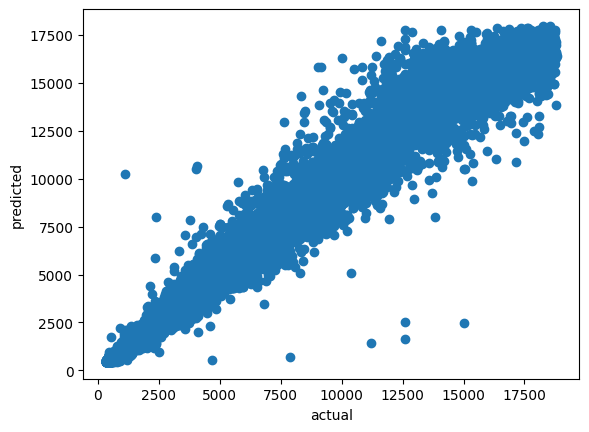

In [36]:
plt.scatter(y_test,y_pred)
plt.xlabel('actual')
plt.ylabel('predicted')

<Axes: xlabel='price'>

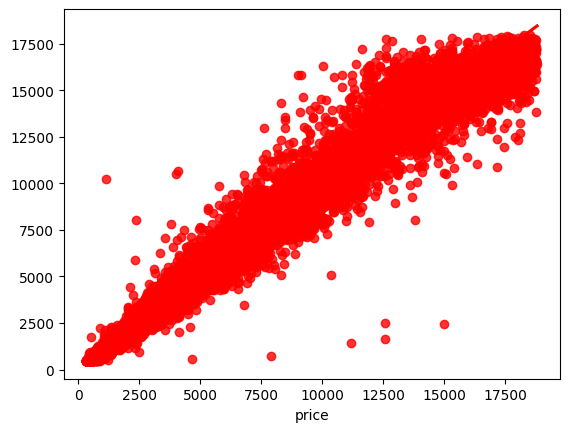

In [37]:
sns.regplot(x=y_test,y=y_pred,ci=None,color='red')